## Environment

In [1]:
#Using latest version of LangChain
import langchain
langchain.__version__

'0.3.17'

### Install Packages

### API Keys

In [3]:
import os, json, re, getpass
import dotenv

dotenv.load_dotenv(".env", override=True)

False

In [4]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [5]:
#Check for Groq API Key
_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


In [6]:
#Check for Tavily API Key
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [7]:
#Check for LangSmith tracing
_set_env("LANGCHAIN_TRACING")

#Check for LangChain API Key - LangSmith
_set_env("LANGCHAIN_API_KEY")

#Check for LangChain endpoint
_set_env("LANGCHAIN_ENDPOINT")

os.environ["LANGCHAIN_PROJECT"] = "agent-class-exercise-4"

LANGCHAIN_TRACING: ··········
LANGCHAIN_API_KEY: ··········
LANGCHAIN_ENDPOINT: ··········


### Libraries

In [8]:
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pydantic import BaseModel, Field

from pprint import pprint

## Selecting Components

### Chat Model

In [9]:
llm = ChatGroq(model="llama3-8b-8192") #llama3-8b-8192, llama-3.1-8b-instant, llama3-groq-8b-8192-tool-use-preview, llama3-groq-70b-8192-tool-use-preview

### Embedding Model

In [10]:
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Vector Store

In [11]:
vector_store = Chroma(embedding_function=embed_model)

## Retriever

First, we index 3 pages.

In [12]:
urls = [
    "https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science",
    "https://www.jioinstitute.edu.in/academics/study-abroad",
    "https://www.jioinstitute.edu.in/experiential-learning"
]

In [13]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [15]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.8 MB/s eta 0:00:00


In [16]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [17]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embed_model,
)

In [18]:
retriever = vectorstore.as_retriever()

## Define Test Questions

In [19]:
#STEP 0 (optional): ADD - Test question for new tool
question_new = "give me about top 2 videos in AI and datascience"

In [20]:
question_search = "Which players in IPL 2025 are expected to draw significant bids"

In [21]:
question_doc = "What are the highlights of the PGP in Data Science and AI course at Jio Institute"

## LLMs

### Router

In [22]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [23]:
# Data model
##STEP 1: ADD - New tool to Literal
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search","video_search_tool"] = Field(
        ...,
        description="Given a user question choose to route it to web search, a vectorstore or video_search_tool. ",
    )

In [24]:
# LLM with function call
structured_llm_router = llm.with_structured_output(RouteQuery)

In [25]:
##STEP 2: MODIFY PROMPT to route to your new tool accordingly
# Prompt
system = """You are an expert at routing a user question to a vectorstore, web search or video search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. If the question talks about a person or place then ise video search. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [26]:
question_router = route_prompt | structured_llm_router
# print(
#     question_router.invoke(
#         {"question": question_new}
#     )
# )
# #print(question_router.invoke({"question": question_doc}))

### Retrieval Grader

In [27]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [28]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [29]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
    for youtube links in the document always grade as relevant"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [30]:
retrieval_grader = grade_prompt | structured_llm_grader
docs = retriever.invoke(question_doc)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question_doc, "document": doc_txt}))

binary_score='yes'


In [31]:
docs

[Document(id='e29a33db-f194-4261-ba5e-bbf9d3d01b66', metadata={'description': "Explore Jio Institute's artificial intelligence course offerings. Dive into the world of AI and data science with our cutting-edge programmes. Apply now!", 'language': 'en', 'source': 'https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science', 'title': 'PGP in Artificial Intelligence & Data Science - Jio Institute'}, page_content='Jio Institute has formulated a seamless digital admissions process to apply to its academic programmes. We invite applications from meritorious students from accross the globe. Eligibility for PGP in Artificial Intelligence & Data Science :A four-year undergraduate degree or its equivalent, in the field of Engineering/Science/ Mathematics and Statistics with minimum 50 per cent or equivalent CGPA. A postgraduate degree (if the undergraduate degree is of three years) in the field of'),
 Document(id='67290add-35d6-40be-b9b9-02bbe8362111', metadata={'description'

### Generate

In [33]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [34]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")

In [35]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [36]:
# Chain
rag_chain = prompt | llm | StrOutputParser()

In [103]:
# Run
generation = rag_chain.invoke({"context": docs, "question": 'tiger in wild videos'})
print(generation)

I don't know. The provided context does not mention "tiger in wild videos."


### Hallucination Grader

In [104]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer"""

    binary_score: str = Field(
        description="Answer, 'yes' or 'no'"
    )

In [105]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [106]:
# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
     Be carful of one exception if the LLM generation has name of person, place, or the term 'videos' always give binary scor eof 'yes'."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [107]:
hallucination_grader = hallucination_prompt | structured_llm_grader

### Answer Grader

In [108]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [109]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

In [110]:
# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question.
     Take care of the exception where if the LLM generation has the term 'videos' or it containes urls from youtube.com always give binary score of 'yes'"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [111]:
generation

'I don\'t know. The provided context does not mention "tiger in wild videos."'

In [112]:
answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question_doc, "generation": generation})

GradeAnswer(binary_score='no')

In [113]:
print(question_doc, "\n\n", generation)

What are the highlights of the PGP in Data Science and AI course at Jio Institute 

 I don't know. The provided context does not mention "tiger in wild videos."


### Question Re-writer

In [114]:
# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n
     Only return the rewritten question and nothing else."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [115]:
question_doc

'What are the highlights of the PGP in Data Science and AI course at Jio Institute'

In [116]:
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question_doc})

'What key takeaways, curriculum, and skill sets can be expected from the PGP in Data Science and AI course at Jio Institute?'

## Tools

### Search Tool

In [117]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [121]:
from langchain.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain.schema import Document

class DuckDuckGoVideoSearchTool:
    def invoke(self, query: dict):
        q = query.get("query", "")
        # Append " video" to target video content

        # Instantiate DuckDuckGoSearchAPIWrapper
        search = DuckDuckGoSearchAPIWrapper()

        # Use the run method
        results = search.run(q + " video")

        return Document(page_content=results)

video_search = DuckDuckGoVideoSearchTool()

print(video_search.invoke({"query": "tiger in wild ,2"}))

page_content='Struggle in the Wild: Reindeer, Camels, and Tigers Stuck in the Mud!In the heart of the wilderness, nature can be both breathtaking and unforgiving. When a p... Rana, a mother tiger, and her cubs reside in Nagarhole National Park, located in southern India. This vast, wet, deciduous forest forms part of the country's... Watch this powerful tiger in its natural habitat, moving gracefully through the wild. 🌳🐅 Experience the beauty and strength of one of nature's most incredi... Video shows the tiger unharmed after it was released in Madhya Pradesh's Veerangana Durgavati Tiger Reserve. Subsection. Asia. Published. 2 days ago. Share. close panel. Share page. Copy link. A surveillance video from China appears to show a farmer narrowly escaping a wild Siberian tiger on November 18 in the Heilongjiang province, Reuters reports.'


## Construct the Graph

Capture the flow in as a graph.

### Define Graph State

We will define a graph.

A `state` object that it passes around to each node.

Our state will have 3 attributes - `question`, `generation` and `documents`.

Each node in our graph will update to it.

In [122]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### Define Graph Flow

We can lay out an agentic RAG graph like this:

* The state has a set of attributes
* Each node will update the state
* Conditional edges decide which node to visit next

#### Nodes

In [123]:
from langchain.schema import Document

In [124]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [125]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [126]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [127]:
question_rewriter

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a question re-writer that converts an input question to a better version that is optimized \n \n     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n \n     Only return the rewritten question and nothing else.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='Here is the initial question: \n\n {question} \n Formulate an improved question.'), additional_kwargs={})])
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7a6cdf23fb10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a6cdf117590>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=Se

In [128]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [129]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    #Condition for Adaptive RAG, that has a flow of web search without a retrieval step first
    if "documents" in state.keys():
        documents = state["documents"]
        documents.append(web_results)
        return {"documents": documents, "question": question}

    else:
        return {"documents": web_results, "question": question}

In [130]:
##STEP 4: ADD new node for your tool (that could directly gives the results / sends a list of documents like Tavily Search)

def video_search_tool(state):
    """
    Video search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---VIDEO SEARCH---")
    question = state["question"]

    # Web search
    video_docs = video_search.invoke({"query": question})
    #video_docs = ast.literal_eval(video_docs)

    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    #Condition for Adaptive RAG, that has a flow of web search without a retrieval step first
    if "documents" in state.keys():
        documents = state["documents"]
        documents.append(web_results)
        documents.append(video_docs)

        return {"documents": documents, "question": question}

    else:
        return {"documents": web_results, "question": question}

In [131]:
import ast

#### Edges

In [132]:
##STEP 5: MODIFY this function as well to include new tool
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    # return source.datasource

    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif source.datasource == 'video_search_tool':
        print("---ROUTE QUESTION TO Video---")
        return 'video_search_tool'

In [133]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [134]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    print(f'documents are{documents}')
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Compile Graph

All these flows are different kinds of **Self-Reflective RAG**, and Adaptive RAG has an additional flow of **Query Analysis**.

#### Flow 1 - Corrective RAG

![image.png](attachment:154f6f10-663f-4395-ae9d-ce17ffbac87b.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/)

In [135]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
graph_1_crag = workflow.compile()

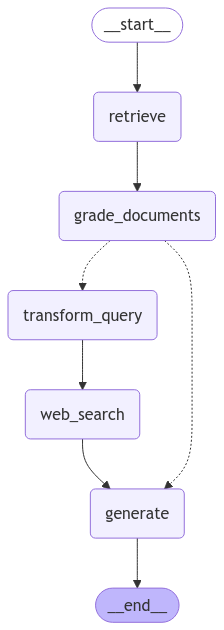

In [136]:
from IPython.display import Image, display

try:
    display(Image(graph_1_crag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 2 - Self-RAG

![image.png](attachment:fef27379-03c6-4085-826f-33d3c2070557.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_self_rag/)

In [137]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_2_selfrag = workflow.compile()

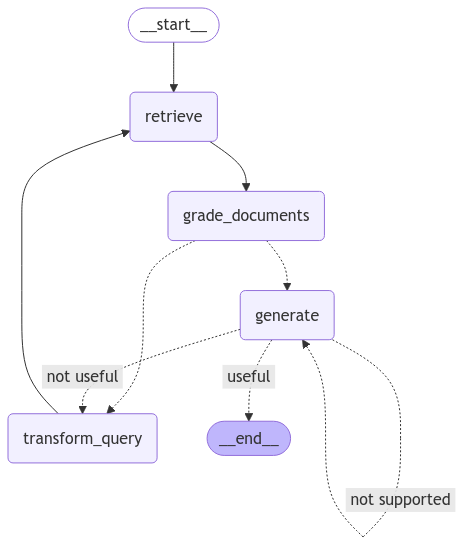

In [138]:
from IPython.display import Image, display

try:
    display(Image(graph_2_selfrag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 3 - Corrective RAG (custom) = Corrective RAG + Hallucination + Answer Relevance Checker

In [139]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_3_crag_custom = workflow.compile()

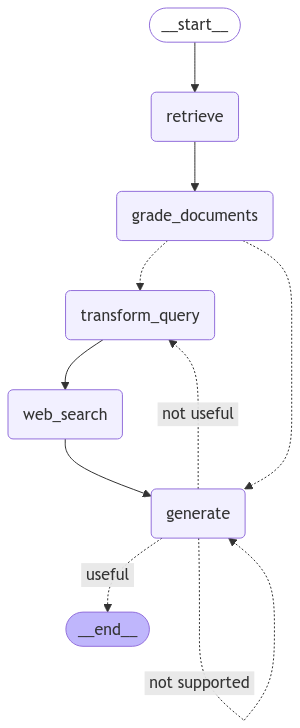

In [140]:
from IPython.display import Image, display

try:
    display(Image(graph_3_crag_custom.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 4 - Adaptive RAG = Self-RAG + Query Analysis

![image.png](attachment:9079738e-a1ed-4534-bf04-f8d48817dd14.png)
[Reference here](https://python.langchain.com/v0.1/docs/use_cases/query_analysis/)

![image.png](attachment:667874de-699e-4766-b8d9-66da8ac82645.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/)

In [141]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("video_search_tool", video_search_tool)  # video search
##STEP 6 ADD new node
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query


# Build graph
# set_conditional_entry_point method doesn't require mentioning START
##STEP 7 MODIFY conditional edge for new tool here
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "video_search_tool" : 'video_search_tool'
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("video_search_tool", "generate")

##STEP 8 ##ADD edge for tool to END if invoking tool returns output /or/ ADD edge like Tavily, which connects to generate
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_4_adaptiverag = workflow.compile()

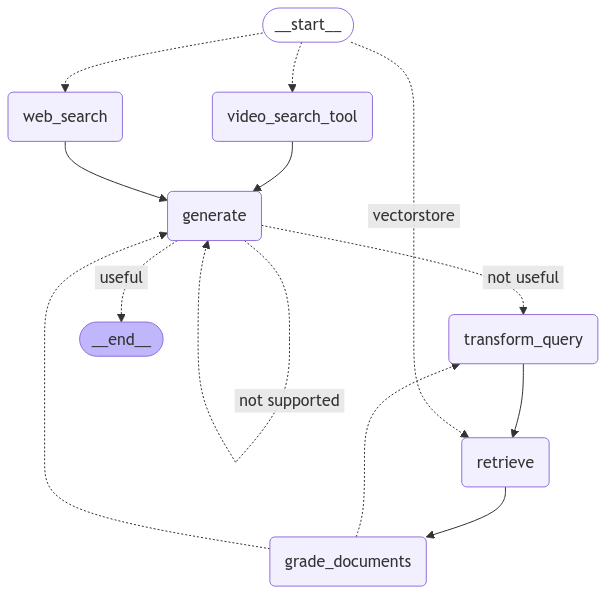

In [142]:
from IPython.display import Image, display

try:
    display(Image(graph_4_adaptiverag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 5 - Adaptive RAG (custom) = Corrective RAG (custom) + Query Analysis

In [143]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
# set_conditional_entry_point method doesn't require mentioning START
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_5_adaptiverag_custom = workflow.compile()

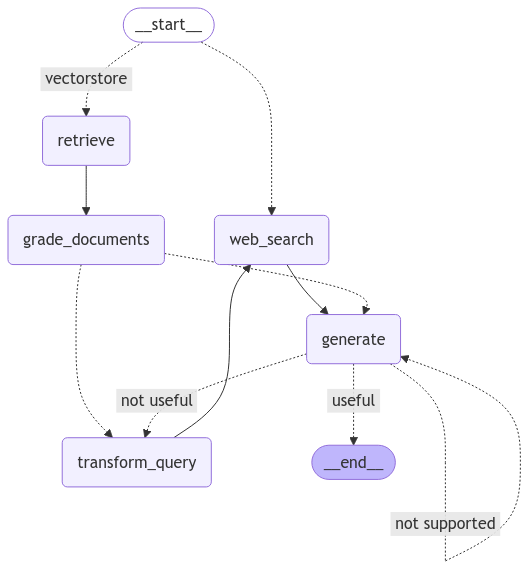

In [144]:
from IPython.display import Image, display

try:
    display(Image(graph_5_adaptiverag_custom.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use Graph

### For Question Not in Context

In [145]:
question_new

'give me about top 2 videos in AI and datascience'

In [146]:
# Run
inputs = {
    "question": question_search
}

In [148]:
# #Self-RAG gets stuck in loop!
# for i,app in enumerate([graph_1_crag, graph_3_crag_custom, graph_5_adaptiverag_custom]):
#     print("FLOW {}----->".format(str(2*i+1))+"\n")
#     for output in app.stream(inputs):
#         for key, value in output.items():
#             # Node
#             pprint(f"Node '{key}':")
#             # Optional: print full state at each node
#             # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
#         pprint("\n---\n")

#     # Final generation
#     pprint(value["generation"])

#     print("---"*20 + "\n\n\n")

### For Question in Context

In [149]:
# for i,app in enumerate([graph_1_crag, graph_2_selfrag, graph_3_crag_custom]):
#     print("FLOW {}----->".format(str(i+1))+"\n")
#     for output in app.stream(inputs):
#         for key, value in output.items():
#             # Node
#             pprint(f"Node '{key}':")
#             # Optional: print full state at each node
#             # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
#         pprint("\n---\n")

#     # Final generation
#     pprint(value["generation"])
#     print("---"*20 + "\n\n\n")

In [150]:
# #Adaptive RAG (custom) is referring to web search, although information is present in the provided context
# for i,app in enumerate([graph_4_adaptiverag, graph_5_adaptiverag_custom]):
#     print("FLOW {}----->".format(str(i+4))+"\n")
#     for output in app.stream(inputs):
#         for key, value in output.items():
#             # Node
#             pprint(f"Node '{key}':")
#             # Optional: print full state at each node
#             # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
#         pprint("\n---\n")

#     # Final generation
#     pprint(value["generation"])
#     print("---"*20 + "\n\n\n")

In [151]:
##STEP 9 - Test with a relevant question that routes to the tool

In [152]:
question_new

'give me about top 2 videos in AI and datascience'

In [153]:
# Run
inputs = {"question": 'donald trump  video'}

In [154]:
video_search.invoke({"query": 'donald trump,1'})

Document(metadata={}, page_content='After being sworn in as the 47th President of the United States, Donald Trump issued his inaugural address, listing his priorities—on trade, immigration, and national security—while ... Watch as President Trump is sworn in to serve as the 47th president as he takes the presidential oath administered by Supreme Court Chief Justice John Roberts. Donald Trump is sworn in as the 47th president of the United States. 00:46 - Source: CNN Politics of the Day 20 videos We will drill, baby, drill," Trump declared. This speech was significantly longer than his 2017 inaugural, which lasted about 16 minutes and was the shortest such address since Jimmy Carter in ... The oath of office and a Melania air kiss - watch the highlights from Donald Trump\'s day. ... Video edited by Sofia Ferreira Santos. 21 January 2025. Washington DC. Trump inauguration 2025.')

In [155]:
#Adaptive RAG (custom) is referring to web search, although information is present in the provided context
for i,app in enumerate([graph_4_adaptiverag]):
    print("FLOW {}----->".format(str(i+4))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")

FLOW 4----->

---ROUTE QUESTION---
---ROUTE QUESTION TO Video---
---VIDEO SEARCH---
"Node 'video_search_tool':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
documents arepage_content='@DonaldJTrumpforPresident. 3.95M subscribers•4.3K videos. This is the official YouTube Channel for President Donald J. Trump. ...more ...more
Donald Trump is currently the 2024 Presidential Candidate of the Republican Party ... Your browser can't play this video. Learn more. Meet the BBQ
This content isn't available. Video from ABC News. FULL REMARKS: Donald Trump speaks at dinner with GOP senators in Mar-a-Lago. 23K views · 1
'Fox News Sunday' anchor Shannon Bream previews an exclusive excerpt of President Donald Trump's interview with Fox News' Bret Baier.
Trump news - breaking news, video, headlines and analysis | CNN Politics CNN10 CNN 5 Things About CNN Work for CNN Watch CNN Getty ImagesTrump and Mexican president say they had a good call – though no sign of backing down on tariff pledge • Ga